Before imputation of the next 6 companies
      PAT    ROE   D/E    GMP     OFS    fresh  PAT_to_fresh  OFS_to_fresh  price_to_PAT  gross_profit_margin  current_ratio  debt_to_assets   log_PAT   log_ROE   log_OFS  log_fresh   ROE_DE  GMP_PAT  total_issue
31   4.93  66.84  0.19    NaN    0.00    33.80      0.145858      0.000000             0                    0       0.000000        0.000000  1.780024  4.217152  0.000000   3.549617  12.6996      NaN        33.80
32  13.03  78.78  0.94    NaN  560.06   138.00      0.094420      4.058406             0                    0     595.808511        0.001678  2.641198  4.379273  6.329828   4.934474  74.0532      NaN       698.06
33   9.68  33.41  1.86  362.5    0.00   290.00      0.033379      0.000000             0                    0       0.000000        0.000000  2.368373  3.538347  0.000000   5.673323  62.1426   1403.6       290.00
34  12.64    NaN   NaN    0.0  501.00  1077.00      0.011736      0.465181             0                  


Model Performance Results:

RandomForest Model:
RMSE: 12.4694
MAE: 8.3058
R2: 0.7602
CV_mean: -833.1466
CV_std: 1188.4175

Prediction Comparison:
    Actual  RandomForest_Pred  RandomForest_Error
27   72.99              72.65                0.33
15    0.00              24.82               24.81
23    9.57               9.26                0.31
17   57.91              55.68                2.22
8    61.45              65.10                3.66
9    40.05              60.34               20.29
29   27.36              33.88                6.52

Average Absolute Prediction Errors:
RandomForest: 8.31

Top 10 Most Important Features:
                      Feature  Importance  Importance_Normalized
  gross_profit_margin GMP_PAT    0.137222               0.137222
      GMP gross_profit_margin    0.073448               0.073448
                  ROE GMP_PAT    0.071365               0.071365
      ROE gross_profit_margin    0.068488               0.068488
          gross_profit_margin    0.0644

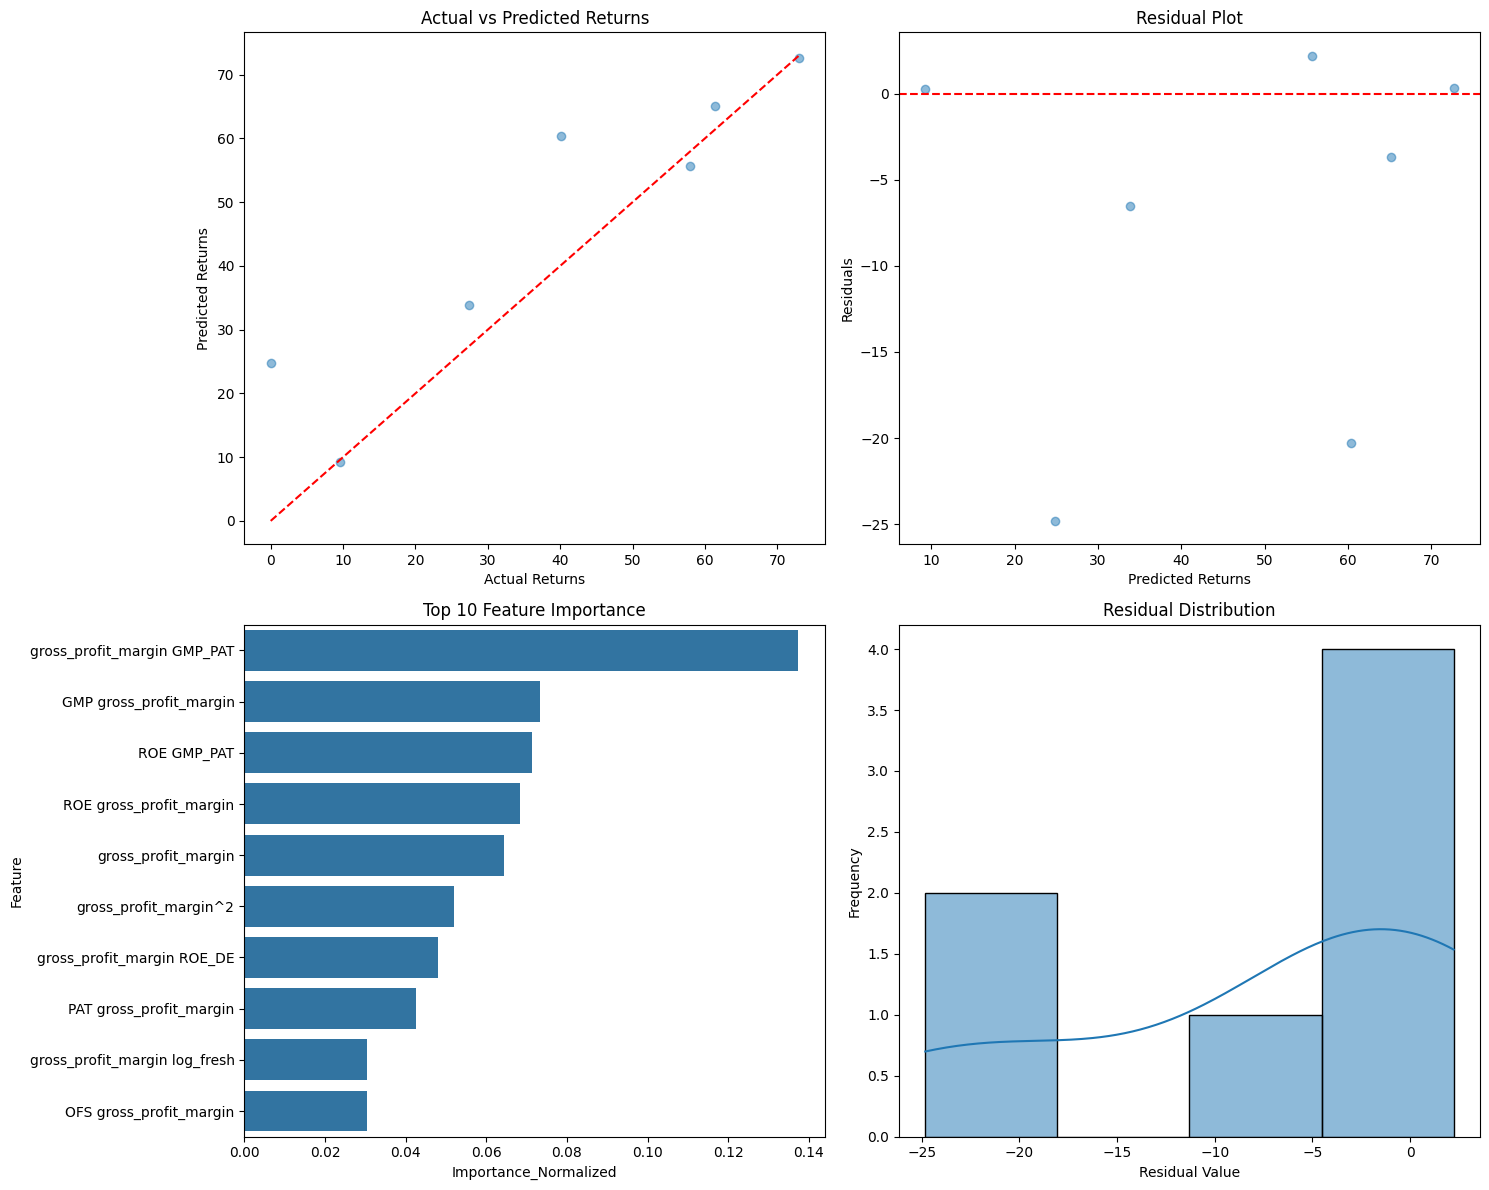


Predictions for the next 6 companies:
Sat Kartar Shopping Limited: Predicted Return = 20.05%
Laxmi Dental Limited: Predicted Return = 25.56%
Quadrant Future Tek Limited: Predicted Return = 24.25%
Capital Infra Trust: Predicted Return = 9.78%
Delta Autocorp Limited: Predicted Return = 14.58%
IPOs Name: Predicted Return = 14.56%


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as snsimport numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import time

# Load the dataset
data = pd.read_csv('/mnt/data/updated_company.csv')

# Data preparation function
def prepare_data(data, scale_factor=2.5, polynomial_degree=2):
    df = data.copy()
    df = df.dropna(subset=['name'])
    numerical_columns = ['PAT', 'ROE', 'D/E', 'GMP', 'OFS', 'fresh', 'open', 'close']
    for col in numerical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df["returns"] = (df["close"] - df["open"]) / df["open"] * 100
    df['PAT_to_fresh'] = df['PAT'] / df['fresh']
    df['OFS_to_fresh'] = df['OFS'] / df['fresh']
    df['price_to_PAT'] = df['open'] / df['PAT']
    df['gross_profit_margin'] = df['GMP'] / df['open']
    df['current_ratio'] = df['OFS'] / df['D/E']
    df['debt_to_assets'] = df['D/E'] / df['OFS']

    for col in ['PAT', 'ROE', 'OFS', 'fresh']:
        df[f'log_{col}'] = np.log1p(df[col])

    df['ROE_DE'] = df['ROE'] * df['D/E']
    df['GMP_PAT'] = df['GMP'] * df['PAT']
    df['total_issue'] = df['OFS'] + df['fresh']

    feature_columns = [col for col in df.columns if col not in ['name', 'Link', 'open', 'close', 'returns']]
    X = df[feature_columns]
    y = df["returns"]

    X['GMP'] = X['GMP'] * scale_factor
    imputer = KNNImputer(n_neighbors=3, weights='distance')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    poly = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
    X_poly = poly.fit_transform(X_imputed)
    X_poly_names = poly.get_feature_names_out(X.columns)
    X_scaled = StandardScaler().fit_transform(X_poly)

    return pd.DataFrame(X_scaled, columns=X_poly_names), y, df

# Prepare data
X_scaled, y, df = prepare_data(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Random Forest model
start_time = time.time()
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model trained in {elapsed_time:.2f} seconds.")

# Make predictions for all companies in the dataset
df['RandomForest_Pred'] = rf.predict(X_scaled)
df['RandomForest_Error'] = abs(df['returns'] - df['RandomForest_Pred'])

# Print prediction comparison
print("\nPrediction Comparison:")
print(df[['name', 'returns', 'RandomForest_Pred', 'RandomForest_Error']].round(2).to_string(index=False))

# Print average absolute prediction error
avg_error = np.nanmean(abs(df['returns'] - df['RandomForest_Pred']))
print(f"\nAverage Absolute Prediction Error: {avg_error:.2f}")

# Function to predict returns for a specific company
def predict_company(company_data):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    scaled_features = StandardScaler().fit_transform(poly.fit_transform(company_data))
    predicted_return = rf.predict(scaled_features)[0]
    return predicted_return

# Interactive prediction loop
while True:
    print("\nEnter import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import time

# Load the dataset
data = pd.read_csv('/mnt/data/updated_company.csv')

# Data preparation function
def prepare_data(data, scale_factor=2.5, polynomial_degree=2):
    df = data.copy()
    df = df.dropna(subset=['name'])
    numerical_columns = ['PAT', 'ROE', 'D/E', 'GMP', 'OFS', 'fresh', 'open', 'close']
    for col in numerical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df["returns"] = (df["close"] - df["open"]) / df["open"] * 100
    df['PAT_to_fresh'] = df['PAT'] / df['fresh']
    df['OFS_to_fresh'] = df['OFS'] / df['fresh']
    df['price_to_PAT'] = df['open'] / df['PAT']
    df['gross_profit_margin'] = df['GMP'] / df['open']
    df['current_ratio'] = df['OFS'] / df['D/E']
    df['debt_to_assets'] = df['D/E'] / df['OFS']

    for col in ['PAT', 'ROE', 'OFS', 'fresh']:
        df[f'log_{col}'] = np.log1p(df[col])

    df['ROE_DE'] = df['ROE'] * df['D/E']
    df['GMP_PAT'] = df['GMP'] * df['PAT']
    df['total_issue'] = df['OFS'] + df['fresh']

    feature_columns = [col for col in df.columns if col not in ['name', 'Link', 'open', 'close', 'returns']]
    X = df[feature_columns]
    y = df["returns"]

    X['GMP'] = X['GMP'] * scale_factor
    imputer = KNNImputer(n_neighbors=3, weights='distance')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    poly = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
    X_poly = poly.fit_transform(X_imputed)
    X_poly_names = poly.get_feature_names_out(X.columns)
    X_scaled = StandardScaler().fit_transform(X_poly)

    return pd.DataFrame(X_scaled, columns=X_poly_names), y, df

# Prepare data
X_scaled, y, df = prepare_data(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Random Forest model
start_time = time.time()
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model trained in {elapsed_time:.2f} seconds.")

# Make predictions for all companies in the dataset
df['RandomForest_Pred'] = rf.predict(X_scaled)
df['RandomForest_Error'] = abs(df['returns'] - df['RandomForest_Pred'])

# Print prediction comparison
print("\nPrediction Comparison:")
print(df[['name', 'returns', 'RandomForest_Pred', 'RandomForest_Error']].round(2).to_string(index=False))

# Print average absolute prediction error
avg_error = np.nanmean(abs(df['returns'] - df['RandomForest_Pred']))
print(f"\nAverage Absolute Prediction Error: {avg_error:.2f}")

# Function to predict returns for a specific company
def predict_company(company_data):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    scaled_features = StandardScaler().fit_transform(poly.fit_transform(company_data))
    predicted_return = rf.predict(scaled_features)[0]
    return predicted_return

# Interactive prediction loop
while True:
    print("\nEnter company details for prediction.")
    try:
        PAT = float(input("PAT: "))
        ROE = float(input("ROE: "))
        DE = float(input("D/E: "))
        GMP = float(input("GMP: "))
        OFS = float(input("OFS: "))
        fresh = float(input("Fresh Issue: "))
        open_price = float(input("Open Price: "))

        company_data = np.array([[PAT, ROE, DE, GMP, OFS, fresh, open_price]])
        predicted_return = predict_company(company_data)
        print(f"Predicted Return: {predicted_return:.2f}%")
    except ValueError:
        print("Invalid input. Please enter numeric values.")

    cont = input("Do you want to predict for another company? (yes/no): ").strip().lower()
    if cont != 'yes':
        break
company details for prediction.")
    try:
        PAT = float(input("PAT: "))
        ROE = float(input("ROE: "))
        DE = float(input("D/E: "))
        GMP = float(input("GMP: "))
        OFS = float(input("OFS: "))
        fresh = float(input("Fresh Issue: "))
        open_price = float(input("Open Price: "))

        company_data = np.array([[PAT, ROE, DE, GMP, OFS, fresh, open_price]])
        predicted_return = predict_company(company_data)
        print(f"Predicted Return: {predicted_return:.2f}%")
    except ValueError:
        print("Invalid input. Please enter numeric values.")

    cont = input("Do you want to predict for another company? (yes/no): ").strip().lower()
    if cont != 'yes':
        break

from scipy import stats
from sklearn.model_selection import KFold
import time

def safe_divide(a, b, fill_value=0):
    """Safely divide two numbers or arrays, handling division by zero."""
    try:
        if pd.isna(a) or pd.isna(b) or b == 0:
            return fill_value
        return a / b
    except:
        return fill_value

def safe_log(x, fill_value=0):
    """Safely compute log of a number or array, handling negative and zero values."""
    try:
        if pd.isna(x) or x <= 0:
            return fill_value
        return np.log1p(x)
    except:
        return fill_value

def prepare_data(data, scale_factor=2.5, polynomial_degree=2):
    """Prepares data for training and prediction, including feature engineering."""
    # Create a copy of the data and remove last 6 companies and empty rows
    df = data.copy()
    df = df.dropna(subset=['name'])
    df = df[df['name'].notna() & (df['name'] != '')]

    # Convert numerical columns
    numerical_columns = ['PAT', 'ROE', 'D/E', 'GMP', 'OFS', 'fresh', 'open', 'close']
    for col in numerical_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    
    # Calculate returns for training set only
    df["returns"] = df.apply(lambda x: safe_divide((x["close"] - x["open"]), x["open"]) * 100, axis=1)
    
    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Feature Engineering - Handle potential division by zero by setting to NaN
    df['PAT_to_fresh'] = df.apply(lambda x: safe_divide(x['PAT'], x['fresh']), axis=1)
    df['OFS_to_fresh'] = df.apply(lambda x: safe_divide(x['OFS'], x['fresh']), axis=1)
    df['price_to_PAT'] = df.apply(lambda x: safe_divide(x['open'], x['PAT']) if x['PAT'] != 0 else np.nan, axis=1)
    

    # Additional Financial Ratios
    df['gross_profit_margin'] = df.apply(lambda x: safe_divide(x['GMP'], x['open']), axis=1)
    df['current_ratio'] = df.apply(lambda x: safe_divide(x['OFS'], x['D/E']), axis=1)
    df['debt_to_assets'] = df.apply(lambda x: safe_divide(x['D/E'], x['OFS']), axis=1)
    
    # Log transform skewed features
    for col in ['PAT', 'ROE', 'OFS', 'fresh']:
        if col in df.columns:
            df[f'log_{col}'] = df[col].apply(safe_log)

    
    # Create interaction terms
    df['ROE_DE'] = df.apply(lambda x: x['ROE'] * x['D/E'] if pd.notna(x['ROE']) and pd.notna(x['D/E']) else np.nan, axis=1)
    df['GMP_PAT'] = df.apply(lambda x: x['GMP'] * x['PAT'] if pd.notna(x['GMP']) and pd.notna(x['PAT']) else np.nan, axis=1)
    
    # Additional features
    df['total_issue'] = df.apply(lambda x: safe_divide(x['OFS'] + x['fresh'], 1), axis=1)

    
    # Separate features and target
    feature_columns = [col for col in df.columns 
                      if col not in ['name', 'Link', 'open', 'close', 'returns'] 
                      and not df[col].isna().all()]
    X = df[feature_columns]
    y = df["returns"]
   
    # Check for low variance columns before scaling
    for col in X.columns:
        if X[col].nunique() <= 1:
           print(f"Warning: {col} in training data has only 1 unique value")
    
    # Apply GMP scaling
    X = X.copy()
    X.loc[:, 'GMP'] = X['GMP'].apply(lambda x: x * scale_factor if pd.notna(x) else x)

    # Replace any remaining infinities with NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Handle missing values using KNN imputation
    imputer = KNNImputer(n_neighbors=min(3, len(X)), weights='distance')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

     # Create polynomial features
    poly = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
    X_poly = poly.fit_transform(X_imputed)
    X_poly_names = poly.get_feature_names_out(input_features = X_imputed.columns)
    X_poly = pd.DataFrame(X_poly, columns=X_poly_names)

    # Use StandardScaler for scaling
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_poly), columns=X_poly.columns)
    
    # Remove any remaining problematic values
    X_scaled = X_scaled.fillna(0)
    X_scaled = X_scaled.replace([np.inf, -np.inf], 0)

    return X_scaled, y, imputer, scaler, df, X_poly_names


def train_random_forest(X, y, X_poly_names):
    """Trains and evaluates the Random Forest regression model."""

    # Hyperparameter Tuning for Random Forest
    param_grid = { # full hyperparameter search space
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [5, 8, 10, 12, 15],
        'min_samples_split': [2, 4, 6, 8],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2', 0.3, 0.5]
    }
    
    rf = RandomForestRegressor(random_state=42)
    
    # Define the scoring metric
    neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better = False)

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=neg_mse_scorer)
    grid_search.fit(X, y)
    
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X)
    
     # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(
                best_rf, X, y, 
                cv=5,
                scoring='neg_mean_squared_error'
            )
    results =  {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std()
    }
        
    return best_rf, results, y_pred, X_poly_names


def analyze_feature_importance(model, feature_names):
    """Analyzes and returns normalized feature importance from a trained model."""
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        })
    else:
      return None
    
    importance = importance.sort_values('Importance', ascending=False).reset_index(drop = True)
    
    # Min-Max scaling (optional)
    # importance['Importance_MinMax'] = (importance['Importance'] - importance['Importance'].min()) / (importance['Importance'].max() - importance['Importance'].min())
    
    # Sum-to-One Normalization
    importance['Importance_Normalized'] = importance['Importance'] / importance['Importance'].sum()
   
    return importance

def plot_diagnostics(y_test, y_pred, feature_importance):
    """Plots diagnostic charts for model evaluation."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Actual vs Predicted
    axes[0, 0].scatter(y_test, y_pred, alpha=0.5)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, 0].set_xlabel('Actual Returns')
    axes[0, 0].set_ylabel('Predicted Returns')
    axes[0, 0].set_title('Actual vs Predicted Returns')
    
    # Residuals
    residuals = y_test - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Returns')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    
    # Feature Importance
    if feature_importance is not None:
         importance_plot = feature_importance.head(10)
         sns.barplot(x='Importance_Normalized', y='Feature', data=importance_plot, ax=axes[1, 0])
         axes[1, 0].set_title('Top 10 Feature Importance')
    
    # Residual Distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Residual Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residual Distribution')
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function to execute the data processing, model training, and prediction."""
    # Read data
    data = pd.read_csv('updated_company.csv')
    
    # Prepare data with enhanced features, including splitting data for the last 6 companies.
    X_scaled, y_train, imputer, scaler, df, X_poly_names = prepare_data(data)
    
    # Train and evaluate models
    start_time = time.time()
    best_rf, results, y_pred, X_poly_names = train_random_forest(X_scaled, y_train, X_poly_names)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time Taken for Random Forest Training: {elapsed_time:.2f} seconds")

    # Get feature importance
    feature_importance = analyze_feature_importance(best_rf, X_poly_names)
    
     # Print model performance results
    print("\nModel Performance Results:")
    for metric_name, value in results.items():
            print(f"{metric_name}: {value:.4f}")
    
    # Print prediction comparison
    print("\nPrediction Comparison:")
    df['RandomForest_Pred'] = y_pred
    print(df[['name','returns','RandomForest_Pred']].round(2).to_string())
    
    # Print average prediction errors
    print("\nAverage Absolute Prediction Errors:")
    avg_error = np.nanmean(abs(df['returns'] - df['RandomForest_Pred']))
    print(f"RandomForest: {avg_error:.2f}")

    print("\nTop 10 Most Important Features:")
    if feature_importance is not None:
       print(feature_importance.head(10).to_string(index=False, max_colwidth=30)) # Show both importance and normalized
    
    # Plot diagnostics
    plot_diagnostics(y_train, y_pred, feature_importance)
    
    # Make predictions for the last 6 companies
    #last_6_companies = df.iloc[-6:].copy()
    #X_predict_scaled = X_scaled.iloc[-6:]
    #predicted_returns = best_rf.predict(X_predict_scaled)
    
    # Display the predicted returns
    #print("\nPredictions for the next 6 companies:")
    #for i, company in enumerate(last_6_companies['name']):
      #  print(f"{company}: Predicted Return = {predicted_returns[i]:.2f}%")

if __name__ == "__main__":
    main()